In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import re
import json

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
#%cd /content/drive/My Drive/openvivqa/training_data/training_images
#!unzip ../training-images.zip


In [ ]:
#%cd /content/drive/MyDrive/test-set
#!unzip test-images.zip

In [ ]:
#%cd /content/drive/MyDrive/openvivqa/dev_set
#%mkdir dev-images
#!unzip /content/drive/MyDrive/openvivqa/dev_set/dev-set/dev-images.zip

In [ ]:
df_training_data = pd.read_json("/content/drive/MyDrive/openvivqa/training_data/vlsp2023_train_data.json")

In [ ]:
df_testing_data=pd.read_json("/content/drive/MyDrive/openvivqa/dev_set/dev-set/vlsp2023_dev_data.json")

In [ ]:
df_private_test_data=pd.read_json('/content/drive/MyDrive/test-set/vlsp2023_test_data.json')

In [ ]:
df_image=df_training_data['images'].dropna()
df_annotation=df_training_data['annotations'].dropna()


In [ ]:
df_testing_image=df_testing_data['images'].dropna()
df_testing_annotation=df_testing_data['annotations'].dropna()

In [ ]:
df_private_image=df_private_test_data['images'].dropna()
df_private_annotation=df_private_test_data['annotations'].dropna()

In [ ]:
def OpenViVQAVisualization(annotation,df_image,testing=False,private=False):
  index_image=annotation['image_id']
  name_img=df_image[index_image]
  if testing==False:
    image=Image.open('/content/drive/MyDrive/openvivqa/training_data/training-images/'+name_img)
  else:
    image=Image.open('/content/drive/MyDrive/openvivqa/dev_set/dev-images/'+name_img)
  if private==True:
    image=Image.open('/content/drive/MyDrive/test-set/test-images' + name_img)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Question: '+annotation['question'])
  if not private:
    print('Answer: '+annotation['answer'])


Answer: hội chợ diễn ra từ ngày 7 đến ngày 8 tháng 1


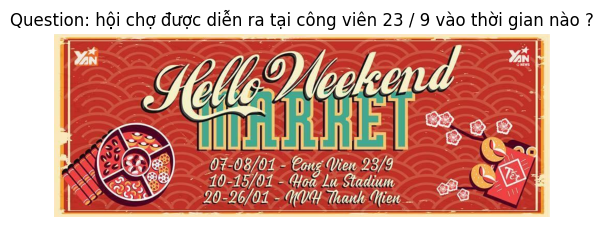

In [ ]:
OpenViVQAVisualization(df_annotation.iloc[19200],df_image)

Answer: ở chu lai , quảng nam


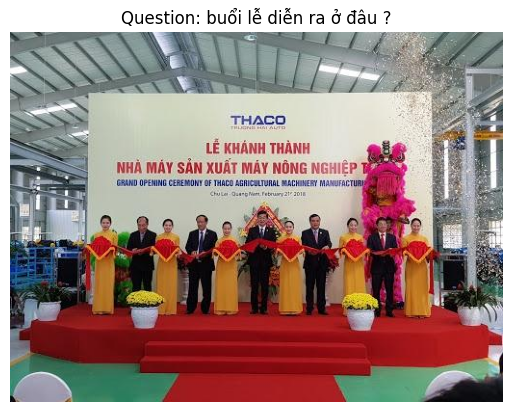

In [ ]:
OpenViVQAVisualization(df_testing_annotation[25093],df_testing_image,testing=True)

# **Dataset**

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.5 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.8 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=b2a8ab2175db3dc0a78edc81fe351bcc2695fcf44b878e40673afed0fcb12dec
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [ ]:
import py_vncorenlp

# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir='/content')

In [ ]:
!pip install tokenizers

In [ ]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content')

In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
class TextTokenizer(nn.Module):
  def __init__(self):
    super(TextTokenizer,self).__init__()
    self.word_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
    self.rdrsegmenter = rdrsegmenter
  def forward(self,text,max_len):
    text=self.rdrsegmenter.word_segment(text)
    text=" ".join(text)
    tokenized = self.word_tokenizer(text, padding=True, return_tensors='pt')
    padded_ids = tokenized['input_ids'].to(device)
    padded_ids = torch.nn.functional.pad(
        padded_ids, (0, max_len-padded_ids.shape[1]), value=0)
    return padded_ids

In [ ]:
emb_ids=TextTokenizer()("Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây.",32)
emb_ids.shape

torch.Size([1, 32])

In [ ]:
class TextEmbedding(nn.Module):
  def __init__(self):
    super(TextEmbedding,self).__init__()
    self.bartpho_word = AutoModel.from_pretrained("vinai/phobert-base-v2").to(device)
  def forward(self, padded_ids):
    with torch.no_grad():
      output=self.bartpho_word(padded_ids)
      last_hidden_state=output[0][:,:,:]
    return last_hidden_state

In [ ]:
embs=TextEmbedding()(emb_ids)
embs.shape

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([32, 768])

In [ ]:
from transformers import BeitImageProcessor, BeitModel

In [ ]:
class VisualEmbedding(nn.Module):
  def __init__(self):
    super(VisualEmbedding,self).__init__()
    self.feature_extractor=BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
    self.model=BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k").to(device)
  def forward(self,image):
    inputs= self.feature_extractor(images=image,return_tensors="pt").to(device)
    with torch.no_grad():
      outputs=self.model(**inputs)
    return outputs[0][0,:,:]



In [ ]:
import requests
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_embeddings=VisualEmbedding()(image)
img_embeddings.shape

Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.weight', 'beit.pooler.layernorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([197, 768])

In [ ]:
class OpenViVQADataset(Dataset):
  def __init__(self,data_images_id, data_annotations, folder_path = '', is_test = False):
    self.data_images_id=data_images_id
    self.data_annotations=data_annotations
    self.folder_path=folder_path
    self.is_test=is_test
    self.text_tokenizer=TextTokenizer()
    self.visual_embedding=VisualEmbedding()
  def __len__(self):
    return len(self.data_annotations)
  def __getitem__(self, idx):
    index_question=self.data_annotations.index[idx]
    index_image=self.data_annotations.iloc[idx]['image_id']
    name_img=self.data_images_id[index_image]
    image = Image.open(self.folder_path + "/" + name_img)
    image_embedding = self.visual_embedding(image)
    question = self.data_annotations.iloc[idx]['question']
    question_ids = self.text_tokenizer(question,32)
    answer=self.data_annotations.iloc[idx]['answer']
    answer_ids=self.text_tokenizer(answer,56)
    return image_embedding,question_ids,answer_ids,index_question

In [ ]:
folder_path_train="/content/drive/MyDrive/openvivqa/training_data/training-images"

In [ ]:
train_dataset = OpenViVQADataset(df_image, df_annotation.iloc[:320], folder_path =folder_path_train)

Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.weight', 'beit.pooler.layernorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
image_embedding,question_ids,answer_ids,index_question=next(iter(train_dataloader))

In [ ]:
question_ids.shape

torch.Size([32, 1, 32])

In [ ]:
answer_ids.shape

torch.Size([32, 1, 56])

In [ ]:
image_embedding.shape

torch.Size([32, 197, 768])

In [ ]:
df_testing_annotation.iloc[:]

In [ ]:
folder_path_test="/content/drive/MyDrive/openvivqa/dev_set/dev-images"
test_dataset = OpenViVQADataset(df_testing_image, df_testing_annotation.iloc[:], folder_path=folder_path_test)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
folder_path_private="/content/drive/MyDrive/test-set/test-images"
private_dataset = OpenViVQADataset(df_private_image, df_private_annotation.iloc[:1000], folder_path=folder_path_private)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
private_dataloader=DataLoader(private_dataset,batch_size=32,shuffle=False)

# **Model**

In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(d_model, d_ff)

        # Non-linearity
        self.activation = nn.GELU()

        # Linear function (readout)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.activation(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class ImageEncoder(nn.Module):
  def __init__(self,d_model,num_head,d_ff,dropout):
    super().__init__()
    self.norm1=nn.LayerNorm(d_model)
    self.norm2=nn.LayerNorm(d_model)
    self.mha=nn.MultiheadAttention(d_model,num_head,batch_first=True)
    self.FFN=FeedforwardNeuralNetModel(d_model,d_ff)
    self.dropout=nn.Dropout(dropout)
  def forward(self,x):
    norm1_output=self.norm1(x)
    mha_output=self.mha(norm1_output,norm1_output,norm1_output)[0]
    x= torch.add(self.dropout(mha_output),x)
    norm2_output=self.norm2(x)
    ffn_output=self.FFN(norm2_output)
    x=x+self.dropout(ffn_output)
    return x



In [ ]:
class QuestionEncoder(nn.Module):
  def __init__(self,d_model,num_head,d_ff,dropout):
    super().__init__()
    self.norm1=nn.LayerNorm(d_model)
    self.norm2=nn.LayerNorm(d_model)
    self.mha=nn.MultiheadAttention(d_model,num_head,batch_first=True)
    self.FFN=FeedforwardNeuralNetModel(d_model,d_ff)
    self.dropout=nn.Dropout(dropout)
  def forward(self,x):
    mha_output=self.mha(x,x,x)[0]
    norm1_output=self.norm1(self.dropout(mha_output))
    x=torch.add(x,norm1_output)
    ffn_output=self.FFN(x)
    norm2_output=self.norm2(self.dropout(ffn_output))
    x=torch.add(x,norm2_output)
    return x


In [ ]:
class ShiftRight(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    x = torch.roll(x, shifts=1, dims=1)
    x[:,0] = 0
    return x

In [ ]:
class ShiftLeft(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    x = torch.roll(x, shifts=-1, dims=2)
    x[:,:,-1] = 0
    return x

In [ ]:
class AnswerDecoder(nn.Module):
  def __init__(self,d_model,num_head,d_ff,dropout):
    super().__init__()
    self.norm1=nn.LayerNorm(d_model)
    self.norm2=nn.LayerNorm(d_model)
    self.norm3=nn.LayerNorm(d_model)
    self.self_mha=nn.MultiheadAttention(d_model,num_head,batch_first=True)
    self.cross_mha=nn.MultiheadAttention(d_model,num_head,batch_first=True)
    self.FFN=FeedforwardNeuralNetModel(d_model,d_ff)
    self.dropout=nn.Dropout(dropout)
    self.text_embedding=TextEmbedding()
  def forward(self,x,y,mask):
    x=ShiftRight()(x)
    x=self.text_embedding(x)
    mha_output=self.self_mha(x,x,x,attn_mask=mask)[0]
    norm1_output=self.norm1(self.dropout(mha_output))
    x=torch.add(x,norm1_output)
    cross_mha_output=self.cross_mha(y,x,x)[0]
    norm2_output=self.norm2(self.dropout(cross_mha_output))
    x=torch.add(x,norm2_output)
    ffn_output=self.FFN(x)
    norm3_output=self.norm3(self.dropout(ffn_output))
    x=torch.add(x,norm3_output)
    return x

In [ ]:
class Model(nn.Module):
  def __init__(self,d_model,tgt_vocab_size, num_head, num_layers, d_ff, max_seq_length, dropout, batch_size,mask):
    super().__init__()
    self.max_seq_length=max_seq_length
    self.batch_size=batch_size
    self.num_head=num_head
    self.ques_mask=mask
    self.text_embedding=TextEmbedding()
    self.image_encoder=nn.ModuleList()
    for _ in range(num_layers):
      self.image_encoder.append(ImageEncoder(d_model,num_head,d_ff,dropout))
    self.question_encoder = nn.ModuleList()
    for _ in range(num_layers):
      self.question_encoder.append(QuestionEncoder(d_model, num_head, d_ff, dropout))
    self.answer_encoder=AnswerDecoder(d_model,num_head,d_ff,dropout)
    self.project_fc=nn.Linear(229,56)
    self.fc=nn.Linear(d_model,tgt_vocab_size)
    self.dropout=nn.Dropout(dropout)

  def forward(self,image_embedding,ques_ids,ans_ids):
    enc_img_output=image_embedding
    for enc_img_layer in self.image_encoder:
      enc_img_output=enc_img_layer(enc_img_output)
    enc_ques_output=self.text_embedding(ques_ids)
    for enc_ques_layer in self.question_encoder:
      enc_ques_output=enc_ques_layer(enc_ques_output)
    enc_output=torch.cat((enc_img_output,enc_ques_output),dim=1)
    enc_output=enc_output.permute(0,2,1).contiguous()
    enc_output=self.project_fc(enc_output)
    enc_output=enc_output.permute(0,2,1).contiguous()
    dec_output=self.answer_encoder(ans_ids,enc_output,self.ques_mask)
    output=self.fc(dec_output)
    return output




In [ ]:
def generate_mask(batch_size,num_head,max_seq_length):
    mask = torch.tril(torch.ones(max_seq_length, max_seq_length)) # 2D

    mask=mask.unsqueeze(0).repeat(batch_size, 1, 1)

    # Expand for heads dimension
    mask=mask.unsqueeze(1).repeat(1, num_head, 1, 1)

    # Merge head and batch dimensions
    mask=mask.view(batch_size*num_head,max_seq_length,max_seq_length).bool()
    return mask

In [ ]:
mask=generate_mask(4,12,56)

# **Not complete**

In [ ]:

#Model(d_model,tgt_vocab_size, num_head, num_layers, d_ff, max_seq_length, dropout, batch_size))
model=Model(768,64000,12,12,512,56,0.1,4,mask).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model6_10.pth'))
model.eval()

In [ ]:
ques_embedding=TextEmbedding()(question_ids.squeeze(1))
ques_embedding.shape

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([4, 32, 768])

In [ ]:
image,question_ids, answer_ids,_ =next(iter(train_dataloader))

In [ ]:
model(image,question_ids.squeeze(1),answer_ids.squeeze(1))

torch.Size([4, 32, 768])
torch.Size([4, 56])


tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [na

In [ ]:
model.train()
for epoch in range(10):
  for image,question_ids, answer_ids,_ in train_dataloader:
    optimizer.zero_grad()
    #forward pass
    output = model(image,question_ids,answer_ids)
    #compute loss
    answer_ids= ShiftLeft()(answer_ids)
    loss = criterion(output.permute(0,2,1), answer_ids.squeeze(1).long())
    #backward pass
    loss.backward()
    #update parameters
    optimizer.step()
    """
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/model8_10.pth') """
  print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


ValueError: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/model5_10.pth')

# **Evaluate and export file**

In [ ]:
model.eval()
word_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
ids=[]
answers=[]
for image,question,answer,question_ids, answer_ids,idx in private_dataloader:

  with torch.no_grad():

    output = model(image,question, answer,question_ids,answer_ids)
    _, predicted_ids = torch.max(output, 2)
    predicts=word_tokenizer.batch_decode(predicted_ids)
    for predict,id in zip(predicts,idx):
        ids.append(str(id.item()))
        predict=predict.replace(' </s>','').replace('</s>','').replace('_','')
        answers.append(predict)

In [ ]:

data = {}
for id, answer in zip(ids, answers):
    data[id] = answer
data

In [ ]:
with open('submission5.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False)

# **Testing**

In [ ]:
image,question,answer,question_ids, answer_ids,idx =next(iter(private_dataloader))
word_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [ ]:
output = model(image,question, answer,question_ids,answer_ids)


In [ ]:
_, predicted_ids = torch.max(output, 2)

In [ ]:
predicted_ids.shape

torch.Size([32, 56])

In [ ]:
answers=word_tokenizer.batch_decode(predicted_ids)
answers[3]

'</s> vào 30 ấp 86 </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>'

In [ ]:
word_tokenizer.decode(question_ids[3,0,:])

'<s> chi_nhánh tiệm làm tóc đức nguyễn ở thành_phố mỹ_tho nằm tại số nhà mấy? </s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>'

Answer: số 30 ấp bắc


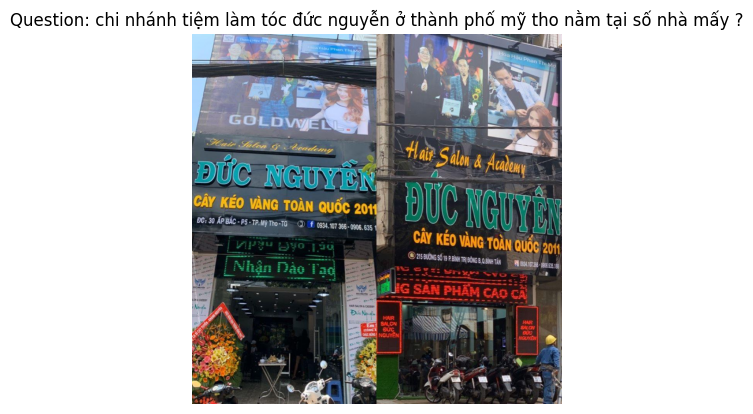

In [ ]:
OpenViVQAVisualization(df_testing_annotation.iloc[3],df_testing_image,testing=True)

In [ ]:
output = model(image,question, answer,question_ids,answer_ids)
_, predicted_ids = torch.max(output, 2)
answer=word_tokenizer.decode(predicted_ids.squeeze(0))

In [ ]:
word_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
predicted_ids.squeeze(0)

tensor([   2,    8, 1664,  138,    2,    2,    2, 2186, 1551,    2,    2,    2,
           2, 1387,    2,    2,    2,    2,    2,    2,    2,    2, 2186,    2,
           2,    2, 3160, 1551, 2186, 2186,    2,   17,    2, 2186,    2, 1701,
          99,    2, 2186,    2,    2,   17, 2186,    2,    2,    2, 1551,    2,
           2, 2186,    2,    2,    2,    2,    2, 1551], device='cuda:0')

In [ ]:
answer

'</s> là h nhau </s> </s> </s> 109</s> </s> </s> </s> m</s> </s> </s> </s> </s> </s> </s> </s> 10</s> </s> </s> 01 91010</s> không </s> 10</s> ng1 </s> 10</s> </s> không 10</s> </s> </s> 9</s> </s> 10</s> </s> </s> </s> </s> 9@@'

In [ ]:
str(idx.item())

'0'

In [ ]:
word_tokenizer.decode(predicted_ids.squeeze(0).squeeze(0))

'</s> là h nhau </s> </s> </s> 109</s> </s> </s> </s> m</s> </s> </s> </s> </s> </s> </s> </s> 10</s> </s> </s> 01 91010</s> không </s> 10</s> ng1 </s> 10</s> </s> không 10</s> </s> </s> 9</s> </s> 10</s> </s> </s> </s> </s> 9@@'

In [ ]:
answer = re.sub("</s>","", answer)
answer

' là h nhau    109    m        10   01 91010 không  10 ng1  10  không 10   9  10     9@@'

In [ ]:
question_ids.squeeze(0).squeeze(0)

tensor([   0,  405, 1611,    7, 4770, 3884,    8,  849,  114,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], device='cuda:0')

In [ ]:
model.eval()
total_loss = 0
val_loader=0
for image,question,answer,question_ids, answer_ids in test_dataloader:

  with torch.no_grad():

    output = model(image,question, answer,question_ids,answer_ids)
    loss = criterion(output.permute(0,2,1), answer_ids.squeeze(1).long())

  total_loss += loss.item()

avg_loss = total_loss / len(val_loader)
print(f"Validation loss: {avg_loss:.2f}")